# DS-GA 3001.001 Special Topics in Data Science: Probabilistic Time Series Analysis

# Week 5 particle filtering

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
from pykalman import KalmanFilter
import time

# Data Visualization
def plot_kalman(time, latent, data, ky=None, ky_var=None, plot_type="r-", label=None, title='sample'):
    """
    Plot the trajectory
    """
    x, y = time, latent
    nx, ny = data[:, 0], data[:, 1]
    fig, ax = plt.subplots(1, 2, figsize=(18, 4))
    if ky is not None:
        ax[0].plot(x, y, 'g-', time, nx, 'b.', time, ny, 'b.', time, ky, 'r-', plot_type)
        if ky_var is not None:
            ax[0].fill_between(time, ky - np.sqrt(ky_var),
                               ky + np.sqrt(ky_var), color='r', alpha=.5, label='estimate')
        ax[0].legend()
        ax[1].plot(y, ky, '.', color='grey')
        ax[1].set_xlabel('real latent')
        ax[1].set_ylabel('estimated latent')
        ax[1].set_title('cc %.3f' %(np.corrcoef(y[:,0], ky)[0,1]))
    else:
        ax[0].plot(x, y, 'g-', x, nx, 'b.', x, ny, 'b.')

        ax[1].plot(y, nx, '.k', label='observed dim 1')
        ax[1].plot(y, ny, '.', color='grey', label='observed dim 2')
        ax[1].set_xlabel('latent')
        ax[1].set_ylabel('observed')
        ax[1].legend()

    ax[0].set_xlabel('time')
    ax[0].set_ylabel('latent')
    ax[0].set_title(title)
    ax[1].set_aspect(1)

    return fig


def print_parameters(kf_model, need_params=None, evals=False):
    """
    Function that prints out the parameters for a Kalman Filter
    @param - kf_model : the model object
    @param - need_params : a list of string
    """
    if need_params is None:
        need_params = ['transition_matrices', 'observation_matrices', 'transition_covariance', 'observation_covariance',
                       'initial_state_mean', 'initial_state_covariance']
    for param in need_params:
        print("{0} = {1}, shape = {2}\n".format(param, getattr(kf_model, param), getattr(kf_model, param).shape))


### example linear dynamical system

transition_matrices = [[0.9]], shape = (1, 1)

observation_matrices = [[1.76405235]
 [0.40015721]], shape = (2, 1)

transition_covariance = [[10.]], shape = (1, 1)

observation_covariance = [[10.  0.]
 [ 0. 10.]], shape = (2, 2)

initial_state_mean = [0.], shape = (1,)

initial_state_covariance = [[1.]], shape = (1, 1)



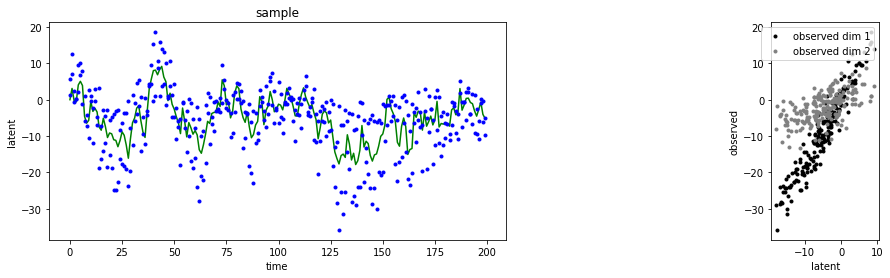

In [14]:
np.random.seed(0)
# Sampling
n_dim_state = 1
n_dim_obs = 2
tt = np.arange(200)
kf_GT = KalmanFilter(n_dim_state=n_dim_state, n_dim_obs=n_dim_obs, 
                  transition_matrices = np.eye(n_dim_state)*.9, 
                  transition_covariance = np.eye(n_dim_state)*10, 
                  observation_matrices = np.random.randn(n_dim_state*n_dim_obs).reshape(n_dim_obs, n_dim_state),
                  observation_covariance = np.eye(n_dim_obs)*10,
                  initial_state_mean = np.zeros(n_dim_state), 
                  initial_state_covariance = np.eye(n_dim_state))
latent, data = kf_GT.sample(len(tt), initial_state=kf_GT.initial_state_mean, random_state=np.random.RandomState(0))
fig = plot_kalman(tt, latent, data, title='sample');
print_parameters(kf_GT)

### use KF to do inference 

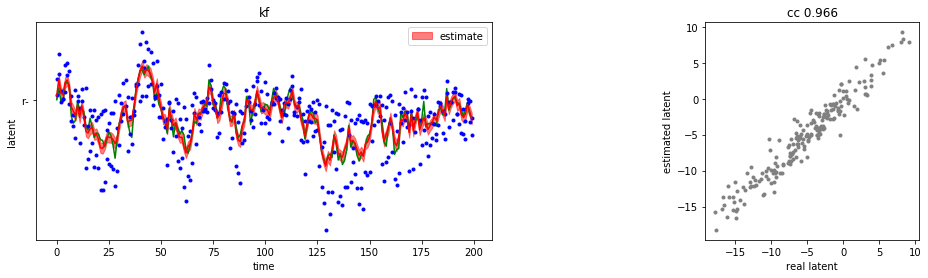

In [15]:
filtered_mean, filtered_cov = kf_GT.filter(data)
smoothed_mean, smoothed_cov = kf_GT.smooth(data)

fig = plot_kalman(tt, latent, data, ky = smoothed_mean[:,0], ky_var=smoothed_cov[:,0,0], title='kf');


## Particle Filtering: alternative inference

*We know*: data and parameters (A, C, $\Gamma$, $\Sigma$)

*We assume*: linear transformation in latent space, linear mapping from latent to observed space, Gaussian observations

<br>
<img src='img/LDS.svg', width = 300, height=300>

*We want*: approximation of the posterior marginals $P(z_n|x_{1:t})$

*How*: generate samples of $P(z_n^{(i)}|z_{n-1})$ through particle filtering, reweigh by observations, and average to obtain expected value

<br>
<img src='img/PF_illustration.svg', width = 200, height=200>


### A) initial samples for $z_1$ 

1) draw $N_{samp}$ samples (=particles) given initial condition $\mu_0$ and $\Gamma_0$

$$P(z_0^{(i)}\rvert \mu_0, \Gamma_0)$$
where $i=1, ..., N_{samp}$

2) propagate samples forward one time step ($n=1$) through linear transformation $A$ and adding noise with covariance $\Gamma$

$$P(z_1^{(i)}\rvert z_0^{(i)})$$

### B) for loop:

#### 1) weigh samples for $z_n^{(i)}$ given observational evidence from $x_n$

2) compute the probability for the data for each sampled $z_n^{(i)}$: 
$$P(x_n|z_n^{(i)})$$

3) compute the weights $w_n^{(i)}$ given $P(x_n|z_n^{(i)})$:
$$w_n^{(i)}=\frac{P(x_n|z_n^{(i)})}{\sum_iP(x_n|z_n^{(i)})}$$

#### 2) produce new samples at $n+1$

4) draw from multinomial distribution with probabilities $w_n$, which will give you class assignments $c_{(i)}$ that indicate which samples $z_n^{(i)}$ to use

5) $z_n^{(c_{(i)})}$ become your new priors form which you sample $z_{n+1}^{(i)}$

$$P\left(z_{n+1}^{(i)}\rvert z_n^{(c_{(i)})}, \Gamma\right)$$

6) keep going WITHIN THE LOOP


# coding: implement the particle filter

In [19]:
class myParticleFiltering:

    def __init__(self, time, transition_matrices, transition_covariance, observation_matrices,
                 observation_covariance, initial_state_mean, initial_state_covariance):
        self.transition_matrices = transition_matrices
        self.transition_covariance = transition_covariance
        self.observation_matrices = observation_matrices
        self.observation_covariance = observation_covariance
        self.initial_state_mean = initial_state_mean
        self.initial_state_covariance = initial_state_covariance
        self.time = time
        # placeholder
        self.est_z_mean = np.zeros(len(time)) * np.nan
        self.est_z_var = np.zeros(len(time)) * np.nan

    def plot_particle_update(self, z_samp, w, Nbins=100, seed=0):
        np.random.seed(seed)
        plt.figure(figsize=(8, 4))
        htmp = np.histogram(z_samp, Nbins)
        plt.fill_between(htmp[1][1:], np.zeros(Nbins), htmp[0], color='blue', alpha=.4, label='sample distribution')
        plt.plot([np.mean(z_samp), np.mean(z_samp)], [0, z_samp.shape[0]/Nbins], 'b-', label='initial mean')
        # create new particles
        k = np.random.multinomial(z_samp.shape[0], w)
        z_samp_new = np.repeat(z_samp, k)
        htmp = np.histogram(z_samp_new, Nbins)
        plt.fill_between(htmp[1][1:], np.zeros(Nbins), htmp[0], color='red', alpha=.4, label='reweighted sample distribution')
        plt.plot([np.mean(z_samp_new), np.mean(z_samp_new)], [0, z_samp.shape[0]/Nbins], 'r-', label='mean of weighted samples')
        plt.legend()
        plt.xlabel('latent $z_n^{(i)}$')
        plt.ylabel('counts')

    def particle_filter(self, data, Nsamp, seed=0):
        ###############################################
        # TODO: implementation of the particle filter #
        ###############################################
        np.random.seed(seed)
        # initial conditions:
        self.est_z_mean[0] = self.initial_state_mean.copy()
        self.est_z_var[0] = self.initial_state_covariance.copy()

        # placeholder
        self.z_samp = np.zeros([Nsamp, len(self.time)])
        self.w = np.zeros([Nsamp, len(self.time)])
        
        ### create samples from distribution with initial conditions
        # TODO: your code here!
        
        #draw Nsamp samples from Gaussian Distribution
        z_samp0 = np.repeat(0, Nsamp) 
        mu, sigma =self.est_z_mean[0],self.est_z_var[0]  # mean and standard deviation
        s_0 = np.random.normal(mu, sigma, Nsamp)
        z_samp0 = s_0 
 
        ### propagate and create samples at time point n=1
        # TODO: your code here!
        #predict sample from transition matrices
        z_samp = np.repeat(0, Nsamp)
        for i in range(Nsamp):
            z_samp[i] = self.transition_matrices * z_samp0[i] + np.random.multivariate_normal(np.zeros(1),np.eye(1))
        
        ### save those samples from n=1
        self.z_samp[:,0] = z_samp.copy()
        
        for nn in range(1, len(self.time)):
            
            ### compute the weights (implement function below)
            w = self.compute_w(data[nn-1, :], z_samp)

            ### keep track of mean and variance of the weighted samples
            # TODO: your code here:
#             lis_for_mean = []
#             for i in range(len(z_samp)):
#                 lis_for_mean.append(w[i]*z_samp[i]) 
            
            self.est_z_mean[nn-1] = np.mean(z_samp)
            self.est_z_var[nn-1] = np.var(z_samp)
        
            ### compute class assignments
            # TODO: your code here:
            k = np.ones(Nsamp)
            k = np.random.multinomial(Nsamp,w)
            
            ### particles according to class assignments (=reweighted particles)
            # TODO: your code here:
            z_samp_new = []
            
            for i in range(Nsamp):
                for j in range(k[i]):
                    z_samp_new.append(z_samp[i])
                
            z_samp_new = np.array(z_samp_new)
            
            ### propagate and create samples at time point n+1 (using the reweighted particles)
            # TODO: your code here:
            z_samp = np.zeros(Nsamp) * np.nan
            for i in range(Nsamp):
                z_samp[i] = self.transition_matrices * z_samp_new[i] + np.random.multivariate_normal(np.zeros(1),np.eye(1))
            
            # save particles and weights
            self.w[:, nn-1] = w   
            self.z_samp[:, nn] = z_samp
            
        # track for last sample:
        self.est_z_mean[-1] = 0
        self.est_z_var[-1] = 1
            

    def compute_w(self, data_nn, z_samp, seed=0):
        np.random.seed(seed)
        ###############################################
        ####### function to compute weights ###########
        ###############################################
        # TODO: your code here:
        pro = []
        for i in range(len(z_samp)):
            mu = self.observation_matrices * z_samp[i]
            sigma = self.observation_covariance
            pro.append(stats.multivariate_normal.pdf(data_nn, mean=mu.T[0], cov=sigma))
    
        x= sum(pro)
        for i in range(len(z_samp)):
            pro[i]=pro[i]/x

        w=np.array(pro)
        return w

In [20]:
# create particle filter class with true parameters
pf = myParticleFiltering(tt, kf_GT.transition_matrices[0], kf_GT.transition_covariance,
                         kf_GT.observation_matrices, kf_GT.observation_covariance, 
                         kf_GT.initial_state_mean, kf_GT.initial_state_covariance)

#### run the particle filter with 1000 particles

In [21]:
start = time.time()
pf.particle_filter(data, Nsamp=1000, seed=1)
end = time.time()
print('time required for particle filter: ', np.round(end-start,3))

time required for particle filter:  33.425


#### look at an example distribution of samples and their corresponding reweighted samples

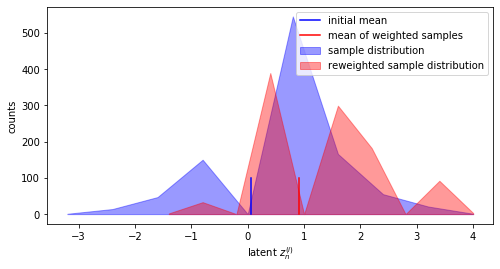

In [22]:
pf.plot_particle_update(pf.z_samp[:,0], pf.w[:,0],Nbins=10)

#### should look something like this ...

<br>
<img src='img/PF_update.svg', width =  500, height=500>


#### particle-filter estimated latent trajectory

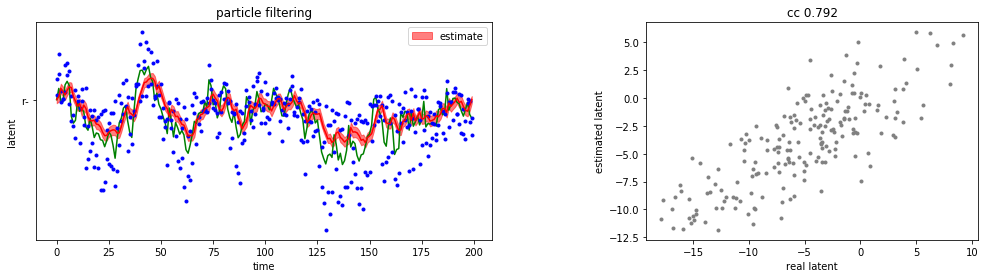

In [23]:
fig = plot_kalman(tt, latent, data, ky = pf.est_z_mean, ky_var=pf.est_z_var, title='particle filtering');

#### should look something like this ...

<br>
<img src='img/PF_1000.svg', width = 1000, height=1000>


#### decrease the number of particles you produce

time required for particle filter:  0.411  sec


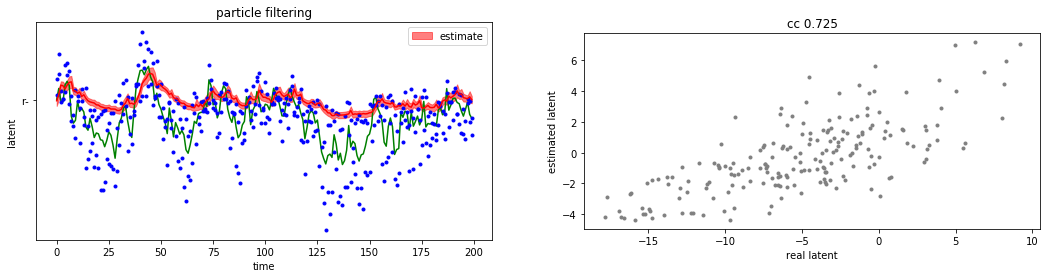

In [24]:
start = time.time()
pf.particle_filter(data, Nsamp=10, seed=1)
end = time.time()
print('time required for particle filter: ', np.round(end-start,3), ' sec')
fig = plot_kalman(tt, latent, data, ky = pf.est_z_mean, ky_var=pf.est_z_var, title='particle filtering');

#### should look something like this ...

<br>
<img src='img/PF_10.svg', width = 1000, height=1000>


#### increase the number of particles you produce

time required for particle filter:  396.552


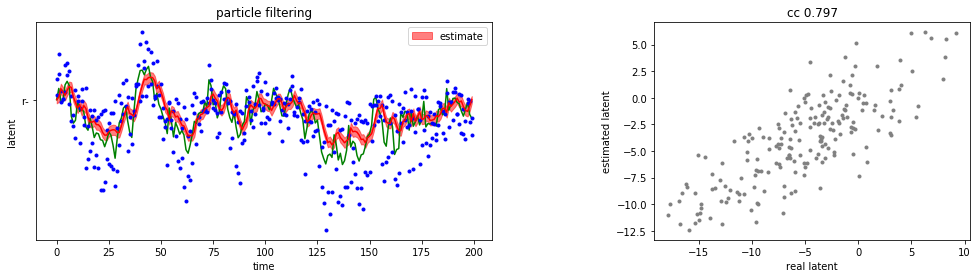

In [25]:
start = time.time()
pf.particle_filter(data, Nsamp=10000, seed=1)
end = time.time()
print('time required for particle filter: ', np.round(end-start,3))
fig = plot_kalman(tt, latent, data, ky = pf.est_z_mean, ky_var=pf.est_z_var, title='particle filtering');

#### should look something like this ...

<br>
<img src='img/PF_10000.svg', width = 1000, height=1000>


### Please turn in the code as a notebook AND as a pdf before 10/26/2021 11:59 pm. Please name your notebook netid.ipynb.

### Your work will be evaluated based on the code and plots. You don't need to write down your answers to these questions in the text blocks. 